In [37]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal
import os.path
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
import os.path 

def radec_to_xyz(ra, dec):
    x = math.cos(np.deg2rad(dec)) * math.cos(np.deg2rad(ra))
    y = math.cos(np.deg2rad(dec)) * math.sin(np.deg2rad(ra))
    z = math.sin(np.deg2rad(dec))

    return np.array([x, y, z], dtype=np.float64)

#functions from sncosmo
def cmb_dz(ra, dec):
    """See http://arxiv.org/pdf/astro-ph/9609034
     CMBcoordsRA = 167.98750000 # J2000 Lineweaver
     CMBcoordsDEC = -7.22000000
    """

    # J2000 coords from NED
    CMB_DZ = 371000. / 299792458.
    CMB_RA = 168.01190437
    CMB_DEC = -6.98296811
    CMB_XYZ = radec_to_xyz(CMB_RA, CMB_DEC)

    coords_xyz = radec_to_xyz(ra, dec)
    
    dz = CMB_DZ * np.dot(CMB_XYZ, coords_xyz)

    return dz

def cmb_to_helio(z, ra, dec):
    """Convert from CMB-frame redshift to heliocentric redshift.
    
    Parameters
    ----------
    z : float
        CMB-frame redshift.
    ra, dec: float
        RA and Declination in degrees (J2000).
    """

    dz = -cmb_dz(ra, dec)
    one_plus_z_pec = math.sqrt((1. + dz) / (1. - dz))
    one_plus_z_helio = (1. + z) * one_plus_z_pec

    return one_plus_z_helio - 1.


In [2]:
def one_lenght_redshift(u):
    
    redshift_value = None
    
    #if there is kind in the list continue
    if "kind" in data[url]["redshift"][0]:

        #if its heliocentric pick then
        if data[url]["redshift"][0]["kind"] == "heliocentric":

            redshift_value = float(data[url]["redshift"][0]["value"])
            print(redshift_value)
        
        #if its cmb pick then    
        if data[url]["redshift"][0]["kind"] == "cmb":

            #convertion of hours to degrees
            if data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "degrees":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.deg))

            elif data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "hours":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.hourangle))

            else:

                print("Erro!")

            redshift_value = float(cmb_to_helio(float(data[url]["redshift"][0]["value"]), c.ra.deg, c.dec.deg))
            print(redshift_value)
      
    #if there is only 1 and its not specificated
    else:
            
        redshift_value = float(data[url]["redshift"][0]["value"])
        print(redshift_value)
    
    return redshift_value

In [3]:
def redshift_selection(url):
    
    redshift_value = None
    
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if there is kind in the list continue
        if "kind" in data[url]["redshift"][nredshift]:

            #if its heliocentric pick then
            if data[url]["redshift"][nredshift]["kind"] == "heliocentric":

                redshift_value = float(data[url]["redshift"][nredshift]["value"])
                print(redshift_value)
                break
                
            
            #if its cmb 
            if data[url]["redshift"][nredshift]["kind"] == "cmb":

                #convertion of hours to degrees
                if data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "degrees":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.deg))

                elif data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "hours":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.hourangle))

                else:

                    print("Erro 1!")

                #convertion of cmb to heliocentric
                redshift_value = float(cmb_to_helio(float(data[url]["redshift"][nredshift]["value"]), c.ra.deg, c.dec.deg))
                print(redshift_value)
                break
            
    return redshift_value

In [4]:
def redshift_HB(url):
    redshift_value = None
    
    maxredshift = None
    
    sumredshift = 0
    HB_test = 0
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if not realize a sum to obtain a mean value
        if "kind" not in data[url]["redshift"][nredshift]:
            
            sumredshift = sumredshift + float(data[url]["redshift"][nredshift]["value"])
                
            #if the sn is in the hubnle flow realize a mean value of the redshifts
            if float(data[url]["redshift"][nredshift]["value"]) > 0.15:
                
                HB_test = 1
                
            #if not the first redshift is the max redshift
            if nredshift == 0:
                maxredshift = float(data[url]["redshift"][nredshift]["value"])
                
            if nredshift > 0 and maxredshift is not None:
                #then analise if the next redshift is grater than max redshift 
                if float(data[url]["redshift"][nredshift]["value"]) > maxredshift:
                        
                    maxredshift = float(data[url]["redshift"][nredshift]["value"])
        
    if HB_test == 1:
            
        #if sne is in the hubble flow realize a mean value
        redshift_value = sumredshift/len(data[url]["redshift"])
        print(redshift_value)  
    elif HB_test == 0:
            
        #if not the maximum redshift is the heliocentric redshift
        redshift_value = maxredshift
        print(redshift_value)
        
    return redshift_value

In [5]:
def redshift_value(url):
    redshift_func = None
    #if there is 1 value use it
    if len(data[url]["redshift"]) == 1:
        
        redshift_func = one_lenght_redshift(url)

    #if not...
    if len(data[url]["redshift"]) == 1 and redshift_func is None:
        
        print("redshift nao encontrado")
        
    if len(data[url]["redshift"]) > 1:
        
        redshift_func = redshift_selection(url)
                
    if len(data[url]["redshift"]) > 1 and redshift_func is None:
        redshift_func = redshift_HB(url)
        
    return redshift_func

In [6]:
def max_time(url):
   
    t0dat = data[url]["maxdate"][0]["value"]
    t0_max_photo = t0dat.split("/")
    t0_max_photo=str(t0_max_photo[0])+'-'+str(t0_max_photo[1])+'-'+str(t0_max_photo[2])
    t0_max_photo=Time(t0_max_photo).mjd
        
    return t0_max_photo
    

In [7]:
def suavization(x):
    
    b, a = signal.butter(8, 0.14)
    y = signal.filtfilt(b, a, x, padlen=0)
    
    return y

In [8]:
'''
def gaussian(wavet, fluxt):
    
    final_flux = [[] for x in range(0,len(final_gradey))]
    
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
    
    spectra = [[] for x in range(0,len(final_gradey))]
    
    
    for l in range(0,len(wavet)):
        
        if len(wavet[l]) > 0:   
            
            interpolation = interp1d(wavet[l][0], fluxt[l][0])

            for j in range(0,len(final_gradey)):

                if min(wavet[l][0]) < final_gradey[j] < max(wavet[l][0]):

                    if interpolation(final_gradey[j]) > 0.001:
                        spectra[j].append([final_gradex[l],interpolation(final_gradey[j])])
    
    
    
    for l in range(0,len(spectra)):
        
        x = []
        y = []
        
        if len(spectra[l]) > 9:
            
            for j in range(0,len(spectra[l])):
                
                x.append([spectra[l][j][0]])
                y.append(spectra[l][j][1])
                
                
        if len(x) > 0:
            
            xidx = []
            for hh in range(0,len(x)):
                
                xidx.append(x[hh][0])
                
            X_ = np.linspace(min(xidx), max(xidx), max(xidx)-min(xidx) + 1)
            
            #print(X_)
            
            gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(x, y)
            
            y_mean= gp.predict(X_[:, np.newaxis])
        
        
        
            final_flux[l].append([X_, y_mean])
            
            
            
    return final_flux
'''

'\ndef gaussian(wavet, fluxt):\n    \n    final_flux = [[] for x in range(0,len(final_gradey))]\n    \n    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))\n    \n    spectra = [[] for x in range(0,len(final_gradey))]\n    \n    \n    for l in range(0,len(wavet)):\n        \n        if len(wavet[l]) > 0:   \n            \n            interpolation = interp1d(wavet[l][0], fluxt[l][0])\n\n            for j in range(0,len(final_gradey)):\n\n                if min(wavet[l][0]) < final_gradey[j] < max(wavet[l][0]):\n\n                    if interpolation(final_gradey[j]) > 0.001:\n                        spectra[j].append([final_gradex[l],interpolation(final_gradey[j])])\n    \n    \n    \n    for l in range(0,len(spectra)):\n        \n        x = []\n        y = []\n        \n        if len(spectra[l]) > 9:\n            \n            for j in range(0,len(spectra[l])):\n                \n                x

In [9]:
sn_names=glob.glob("*.json")
#sn_names=["*.json"]
'''
file = open("newtraining.txt")
lines = file.readlines()
file.close()

sn_names = []

for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
    sn_names.append(co[0])
'''

'\nfile = open("newtraining.txt")\nlines = file.readlines()\nfile.close()\n\nsn_names = []\n\nfor line in lines:\n    if line.startswith(\'#\'): continue\n    co=line.rstrip().replace(\'INDEF\',\'Nan\').split()\n    sn_names.append(co[0])\n'

In [10]:
len(sn_names)

380

In [11]:
#save_path = '/home/user/Área de Trabalho/salt2templates/data'

In [12]:
#saltname="salt2_template_0.dat"

In [13]:
#file = open(saltname)
#lines = file.readlines()
#file.close()

In [14]:
'''
x_salt = []
y_salt = []
z_salt = []

#to separate the collumns
for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
        
    #saving in temporary lists
    x_salt.append(co[0])
    y_salt.append(co[1])
    z_salt.append(co[2])

#to float
x_salt = np.array(x_salt, dtype=float)
y_salt = np.array(y_salt, dtype=float)
z_salt = np.array(z_salt, dtype=float)
'''

"\nx_salt = []\ny_salt = []\nz_salt = []\n\n#to separate the collumns\nfor line in lines:\n    if line.startswith('#'): continue\n    co=line.rstrip().replace('INDEF','Nan').split()\n        \n    #saving in temporary lists\n    x_salt.append(co[0])\n    y_salt.append(co[1])\n    z_salt.append(co[2])\n\n#to float\nx_salt = np.array(x_salt, dtype=float)\ny_salt = np.array(y_salt, dtype=float)\nz_salt = np.array(z_salt, dtype=float)\n"

In [15]:
'''
maxv = []
for i in range(0, 71):
    
    maxv.append(z_salt[721*i + 500])
'''

'\nmaxv = []\nfor i in range(0, 71):\n    \n    maxv.append(z_salt[721*i + 500])\n'

In [16]:
final_gradex = np.linspace(-20, 50, 71)
final_gradey = np.linspace(2000, 9200, 721)

list_data = [[]for y in range(0,len(final_gradey))]
number_data_density = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 

wave = [[] for x in range(0,len(final_gradex))]
flux = [[] for x in range(0,len(final_gradex))]

namestime = [[] for x in range(0,len(final_gradex))]

for u in range(0,len(sn_names)):
    
    print(sn_names[u])

    #reading the .json file
    with open(sn_names[u], "r") as read_file:
        data = json.load(read_file)

    #catching the name of supernova
    url=sn_names[u]
    if url.endswith('.json'):
        url = url[:-5]
    #print(url)
    #defining the lists

    redshift = redshift_value(url)
        
    #print("valor final")    
    #print(redshift)
    
    
    spec_functions = []
    max_min = []
    
    t0 = max_time(url)
    if redshift is not None and t0 is not None:
        
        #spectra data
        i=0
        n=0
        while i < len(data[url]["spectra"]):


            if "time" in data[url]["spectra"][i]:

                spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                #print(spectratime)

            alert3 = 0
            #if its the first spectra then previous time is the first time
            if i == 0:
                previoustime = spectratime

            else:
                #if the diference between the time and previous time is more than * days so emmit an alert to continue
                if (spectratime - previoustime) < 2000:

                    alert3 = 1
                    previoustime = spectratime

            #if the diference of time is less than * continue
            if alert3 == 1:

                #verifing if its calibrated and if it have a redshift correction 
                alert1 = 0 #for calibration
                alert2 = 0 #for redshift correction

                if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                    alert1 = 1 #first alert

                    if "deredshifted" in data[url]["spectra"][i]:
                        alert2 = 1 #second alert

                #if its calibrated and corrected
                if alert1 == 1 and alert2 == 1:

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

                #if its calibrated, redshift not adjusted but with a clear redshift
                elif alert1 ==1 and alert2 == 0:   

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

            i = i + 1

       
        
        if n > 4:
        

            #print(redshift)
            spectra_data = 0
            i=0
            n=0
            times = []
            max_fluxes = []
            time_verification = 0
            wavelength_verification = 0
            while i < len(data[url]["spectra"]):

                if "time" in data[url]["spectra"][i]:

                    spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                    #print(spectratime)
                    #verifing if its calibrated and if it have a redshift correction 
                    alert1 = 0 #for calibration
                    alert2 = 0 #for redshift correction

                    if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                        alert1 = 1 #first alert

                        if "deredshifted" in data[url]["spectra"][i]:
                            alert2 = 1 #second alert

                    #if its calibrated and corrected
                    if alert1 == 1 and alert2 == 1:
                        #print("ok")
                        #there are 3 collumns: wavelength flux and flux error
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            
                 
                            #making a list of lists 
                            
                            suavf = suavization(fluxtemp)
                                               
                            for x in range(0,len(final_gradex)):

                                if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                    wave[x].append(df['wavelength'])
                                    flux[x].append(suavf)  
                                    namestime[x].append(url)
                                
                        
                        
                        #there are 2 collumns: wavelength and flux
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            
              
                            #making a list of lists 
                            suavf = suavization(fluxtemp)

                            for x in range(0,len(final_gradex)):
                            
                                if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                    wave[x].append(df['wavelength'])
                                    flux[x].append(suavf)  
                                    namestime[x].append(url)
       

                            
                    #if its calibrated, redshift not adjusted but with a clear redshift
                    if alert1 ==1 and alert2 == 0:   

                        #there are 3 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)


                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time
                 
                            #making a list of lists 
                            suavf = suavization(fluxtemp)
                            
                            for x in range(0,len(final_gradex)):

                                if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                    wave[x].append(df['wavelength'])
                                    flux[x].append(suavf)  
                                    namestime[x].append(url)
                             
                            
                            
                            
                        #there are 2 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)

                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time
               
                            #making a list of lists 
                            suavf = suavization(fluxtemp)                       
                                                       
                            for x in range(0,len(final_gradex)):

                                if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                    wave[x].append(df['wavelength'])
                                    flux[x].append(suavf)
                                    namestime[x].append(url)
                                    
                i = i + 1



SN2006gr.json
0.034601
SN2004gc.json
0.030679357865528
SN2004as.json
0.031021
SN2011ay.json
0.021
SN2002dj.json
0.009393
SN2001ay.json
0.03024
SN2012hd.json
0.012
SN2008dr.json
0.041449
SN1989B.json
0.002425
SN2002es.json
0.02843
SN2013cs.json
0.009
SN2005al.json
0.012381930324267376
SN2000ce.json
0.01631
SN2006N.json
0.014277
SN2008ia.json
0.02197002237988821
SN2009ig.json
0.00885
SN1999cp.json
0.00948
SN2006ax.json
0.016725
SN1998bn.json
0.005981
SN2008C.json
0.01660210068034762
SN1999cl.json
0.007609
SN2006dy.json
0.007679
SN2003it.json
0.025121
SN2008ar.json
0.026147
SN2001E.json
0.01926
SN2007hb.json
0.035184
SN2002fk.json
0.007132
SN1999X.json
0.02517
SN2001gc.json
0.01929
PTF09dnp.json
0.037559
iPTF14bdn.json
0.01558
SN2009aa.json
0.02731
SN1998es.json
0.01057
SN1997br.json
0.006941
SN1993Z.json
0.00452
SN2008J.json
0.015874
SN2005eq.json
0.028974294942283096
SN2003Y.json
0.01694
SN2005eo.json
None
SN1996X.json
0.00749
SN1956A.json
0.00559
LSQ12ehh.json
0.1


LSQ12fhs.json
0.033145
SN2009dc.json
0.02158
SN2008ha.json
0.004623
SN1999ek.json
0.01752
SN1989M.json
0.00507
SN2001fe.json
0.013539
SN2001ck.json
0.034721
SN2002bo.json
0.00424
SN2006ej.json
0.020458277727554597
SN2003fd.json
0.060222
SN2001en.json
0.015871
SN2003M.json
0.02424
SN2002ey.json
0.038783
SN2001bg.json
0.007122
SN2001ex.json
0.02638
SN2005eu.json
0.034901
SN1991K.json
0.017
SN2006sr.json
0.02414
SN2007cq.json
0.0259
PTF10ops.json
0.06
SN2008Q.json
0.007935
SN2002aw.json
0.026145
SN2001N.json
0.021025
SN2007ca.json
0.014066
SN2004eo.json
0.015704256114751347
SN2005ls.json
0.021118
SN2005hc.json
0.045948829040162176
SN2001br.json
0.020628
SN2002fb.json
0.015567
SN2005hk.json
0.01306
SN1998aq.json
0.003699
SN2003ic.json
0.055672
SN2006cf.json
0.041549
SN1998co.json
0.01807
SN1997dt.json
0.007318
SN2006cm.json
0.016341
SN2016coj.json
0.004483
SN2012ht.json
0.003559
SN2007gi.json
0.00482
LSQ12fxd.json
0.031
SN2005hj.json
0.05802511117307718
SN1992A.json
0.00626
SN2012fw.json
0

## Normalizacao dos espectros

In [17]:
a = 20

In [18]:
len(flux[a])

99

In [19]:
histomax = []

In [20]:
for i in range(0,len(flux[a])):
    
    #if its in the maximum region
    if min(wave[a][i]) < 3900 and max(wave[a][i]) > 4100:

        #print(flux[a][i])

        if 3900 < wave[a][i][list(flux[a][i]).index(max(flux[a][i]))] < 4100:

            histomax.append([max(flux[a][i]),i])
    #print(i)

In [21]:
nhistomax = []
for i in range(0,len(histomax)):
    
    nhistomax.append(histomax[i][0])

<IPython.core.display.Javascript object>


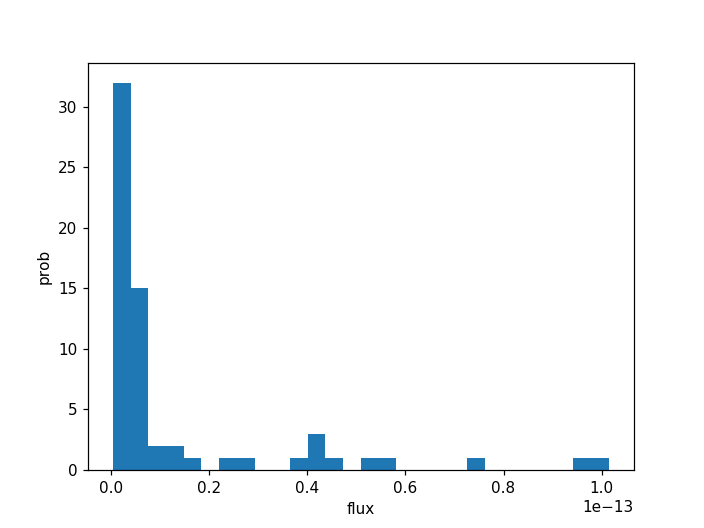

In [22]:
%matplotlib notebook
plt.hist(nhistomax,bins='auto')
#plt.xlim(xmin=min(histomax), xmax = 0.5*10**(-13))
plt.ylabel('prob');
plt.xlabel('flux');
plt.show()

In [23]:
binrange = (max(nhistomax)-min(nhistomax))/50

In [24]:
binrange

2.022932308987203e-15

In [25]:
fluxvector = [[]for y in range(0,51)]

In [26]:
for i in range(0,len(fluxvector)):
    
    #if its the first step of the loop
    if i == 0:
        xmin = min(nhistomax)

        xmax = xmin + binrange
    
    #searching in the list
    for j in range(0,len(nhistomax)):
        
        #separating into the lists
        if xmin <= nhistomax[j] <= xmax:
            
            fluxvector[i].append(nhistomax[j])
            
    xmin = xmax
    
    xmax = xmax + binrange

In [27]:
lenghts = []

for i in range(0,len(fluxvector)):

    lenghts.append(len(fluxvector[i]))

In [28]:
lenghts

[21,
 16,
 7,
 3,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1]

In [29]:
#finding the mode of the distribution
mode = [i for i,x in enumerate(lenghts) if x == max(lenghts)]

In [30]:
medmode = np.mean(fluxvector[mode[0]])

In [31]:
nwave = [[] for x in range(0,len(final_gradex))]
nflux = [[] for x in range(0,len(final_gradex))]
nnamestime = [[] for x in range(0,len(final_gradex))]

In [32]:
#normalizing by the max value
for i in range(0,len(histomax)):
    
    factor = medmode/histomax[i][0]
    
    nwave[a].append(wave[a][histomax[i][1]])
    nflux[a].append(flux[a][histomax[i][1]]*factor)
    nnamestime[a].append(namestime[a][histomax[i][1]])

<IPython.core.display.Javascript object>


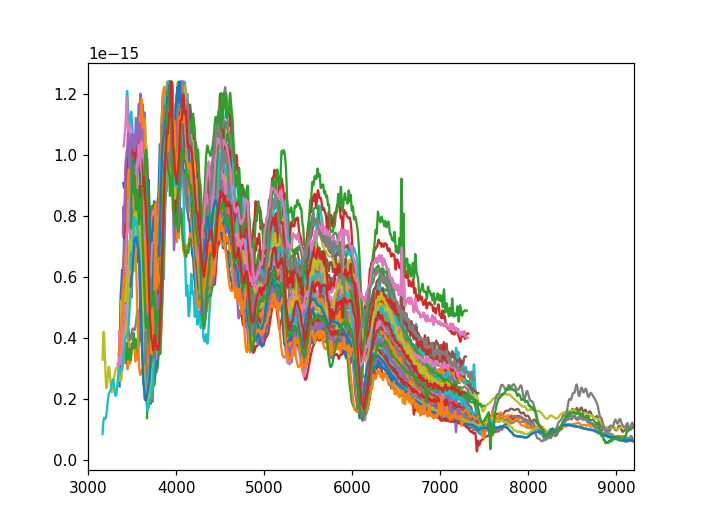

In [33]:
%matplotlib notebook
for i in range(0,len(nwave[a])):
    
    plt.plot(nwave[a][i], nflux[a][i])

plt.xlim(3000,9200)
plt.show()

In [44]:
save_path = '/home/joao/Documentos/Work/templates/data'

In [87]:
for i in range(0,len(nwave[a])):

    table = []
    for k in range(0,len(nwave[a][i])):
        table.append((nwave[a][i][k], nflux[a][i][k]))


    name_of_file = str(nnamestime[a][i])+'_'+str(int(final_gradex[a]))

    completeName = os.path.join(save_path, name_of_file+".dat")  


        
    f = open(completeName, 'w')
    f.write(tabulate(table, tablefmt="plain"))
    f.close()

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [88]:
nnamestime[a]

['SN2006gr',
 'SN2006ax',
 'SN2003it',
 'SN2002fk',
 'SN1998es',
 'SN2001en',
 'SN2006sr',
 'SN2008Q',
 'SN2005hc',
 'SN2002fb',
 'SN1998aq',
 'SN2006hb',
 'SN2006hb',
 'SN2002ar',
 'SN2003cq',
 'SN2007af',
 'SN2007af',
 'SN2004gs',
 'SN2002kf',
 'SN2002jy',
 'SN1998dh',
 'SN2003iv',
 'SN1998bp',
 'SN2009D',
 'SN2002ck',
 'SN1999dq',
 'SN2004at',
 'SN2006is',
 'SN2005el',
 'SN2005el',
 'SN2007A',
 'SN2007A',
 'SN2000cx',
 'SN2006S',
 'SN2006S',
 'SN2002de',
 'SN2007kk',
 'SN2008R',
 'SN2013ew',
 'SN2013ew',
 'SN2005cf',
 'SN2003ch',
 'SN1997bp',
 'SN2002bz',
 'SN1999ac',
 'SN1994D',
 'SN2008Z',
 'SN2007bd',
 'SN2004ef',
 'SN2001da',
 'SN2005na',
 'SN2014aa',
 'SN2004L',
 'SN2007F',
 'SN2007F',
 'SN2007S',
 'SN2007S',
 'SN2003W',
 'SN2012fr',
 'SN2012fr',
 'SN2012fr',
 'SN2002hu',
 'SN2015bp',
 'SN1998eg']